# Tutorial 7: Liver Cancer Analysis (Xenium)

<p align="left">
  <img src="../../_static/liver.png" width="150">
</p>
> This tutorial demonstrates how to identify spatial domains on Xenium data from liver cancer by SemanticST.


<div class="alert alert-block alert-info">
<b>None-responder</b> 
<br>
First we analyse non-responder patient and enable mini-batch training.
</div>

## Import necessary packages

In [1]:
from sklearn import metrics
import torch
import copy
import os
import random
import numpy as np
from semanticst.loading_batches import PrepareDataloader
from semanticst.loading_batches import Dataloader
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import torch.utils.data as data
from semanticst.main import Config
import warnings
warnings.filterwarnings("ignore")
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

/home/rokny/miniconda3/envs/semanticST/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


## Read data and import device

In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"You are using *{device}*")
BASE_PATH = Path('/media/rokny/DATA1/Roxana/Data/Ankur/MS19/MS19_feature.h5ad')
spot_paths= Path(f'{BASE_PATH}')

You are using *cuda:1*


In [2]:
from semanticst.loading_batches import PrepareDataloader


/home/roxana/anaconda3/envs/semanticst3/lib/python3.9/site-packages/torch/__config__.py:10: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._show_config()


In [3]:
from semanticst.loading_batches import PrepareDataloader
dtype = "Xenium"  
config = Config(spot_paths=spot_paths,device=device,dtype=dtype, use_mini_batch=True)
config_used = copy.copy(config)
loader = PrepareDataloader(config_used)
train_loader, test_loader, num_iter, adata = loader.getloader()
print(adata)

sample_num : 316350
batch_size : 3000
AnnData object with n_obs × n_vars = 316350 × 319
    obs: 'ground_truth', 'ground_truth_version2', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    obsm: 'spatial'


<h3>3. Plot Azimuth annotation!</h3>

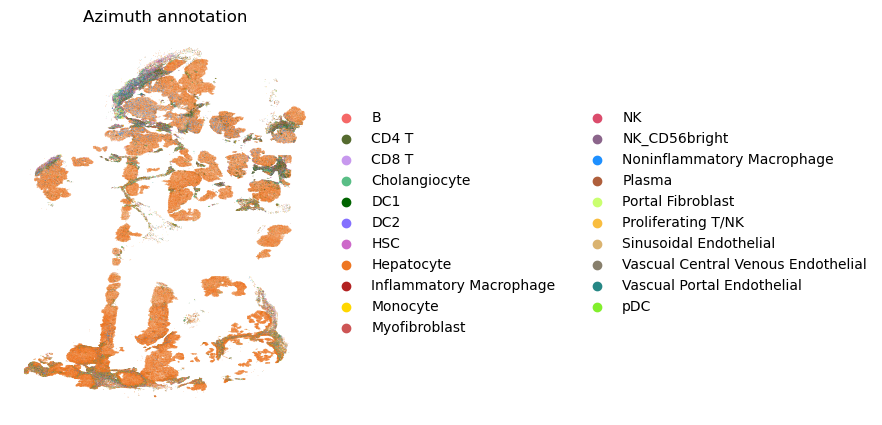

In [4]:
plt.rcParams["figure.figsize"] = (4,5)
plot_color=["#F56867","#556B2F","#C798EE","#59BE86","#006400","#8470FF",
            "#CD69C9","#EE7621","#B22222","#FFD700","#CD5555","#DB4C6C",
           "#8B658B","#1E90FF","#AF5F3C","#CAFF70", "#F9BD3F","#DAB370",
           "#877F6C","#268785", '#82EF2D', '#B4EEB4']
adata.obsm['spatial'][:, 1] = -1 * adata.obsm['spatial'][:, 1]

sc.pl.embedding(adata, basis="spatial", color="ground_truth",palette=plot_color, show=False, title='Azimuth annotation')
plt.gca().invert_yaxis()  # This will invert the y-axis
plt.axis('off')
plt.show()

## Run the model with mini-batch training

In [4]:
from semanticst.SemanticST_main import Semantic_batches as Trainer 
model = Trainer(adata, train_loader,test_loader, num_iter,config)  
adata=model.train()  # Train the model


🚀 Welcome to SemanticST! 🚀

📢 Recommendation: If your dataset contains more than 40000 spots or cells, we suggest using **mini-batch training** for efficiency.

✅ Using Mini-Batch Training for better efficiency! 🏋️‍♂️
Begin to train ST data...


Training Progress: 100%|██████████████████████| 106/106 [07:19<00:00,  4.15s/it]


Optimization finished for ST data!


Testing Progress: 100%|████████████████████| 106/106 [00:59<00:00,  1.78batch/s]


## Clustering

In [5]:
n_cluster =20
tool='mclust'
from semanticst.utils import clustering
clustering(adata,seed=2025, n_clusters=n_cluster, method=tool,key='emb_decoder')
#save clustering results
np.save("domain_Xenium_mclust_21_MS26_2.npy",adata.obs['domain'])

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


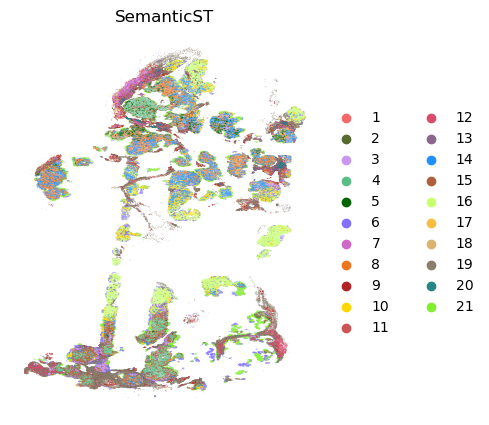

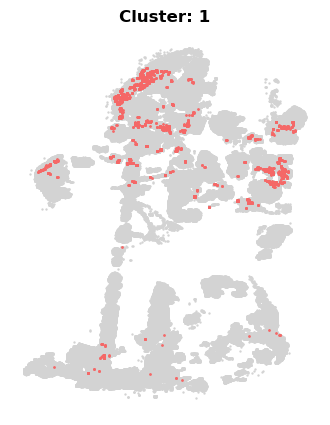

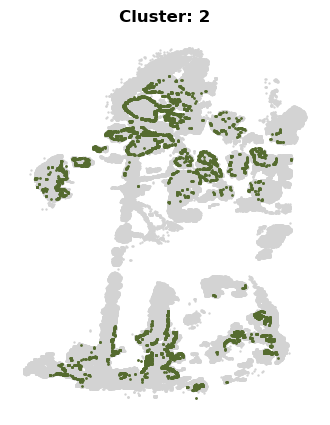

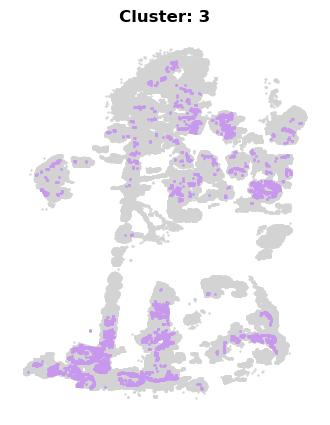

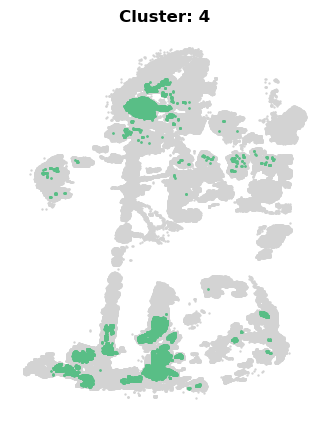

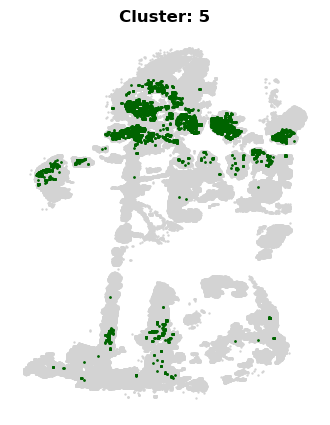

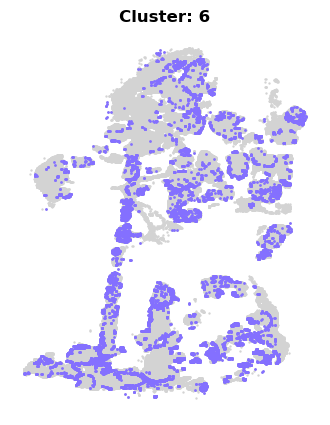

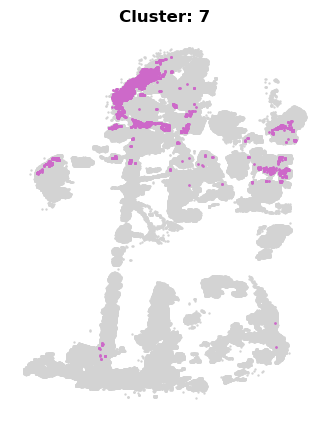

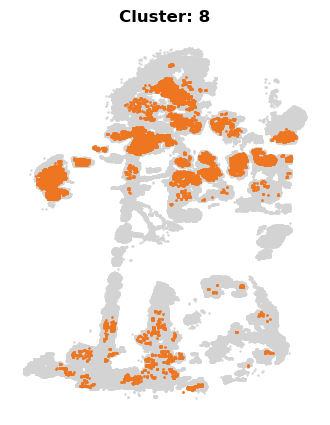

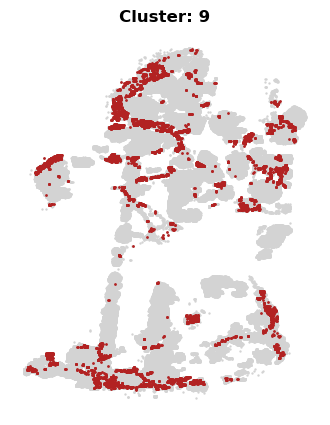

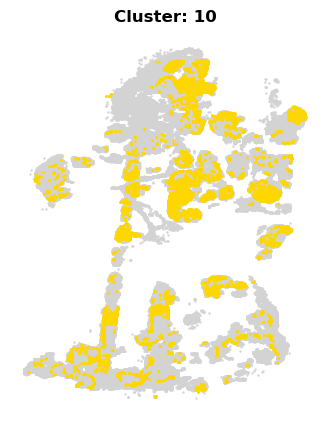

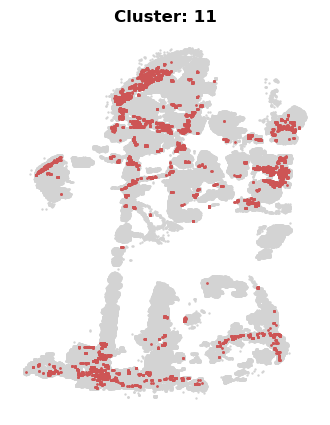

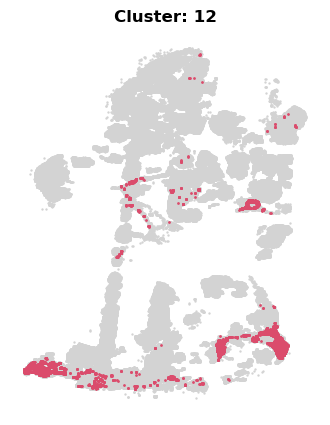

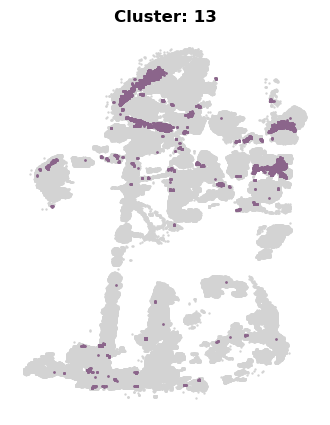

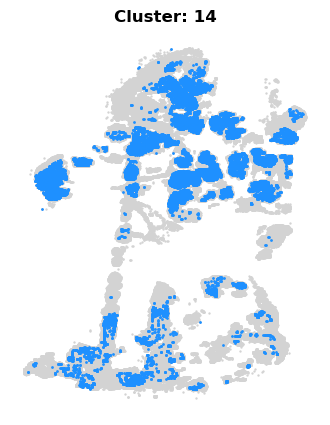

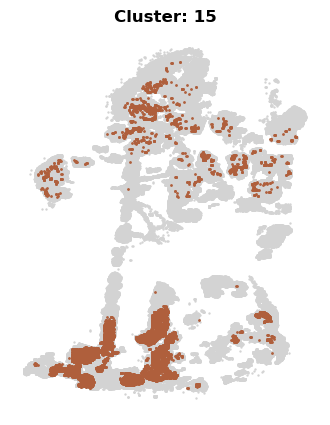

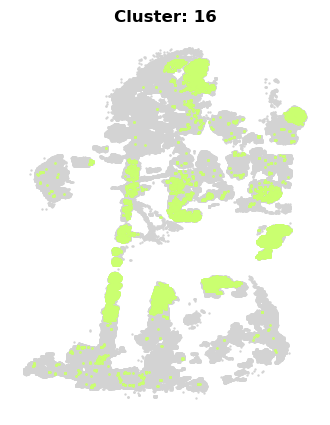

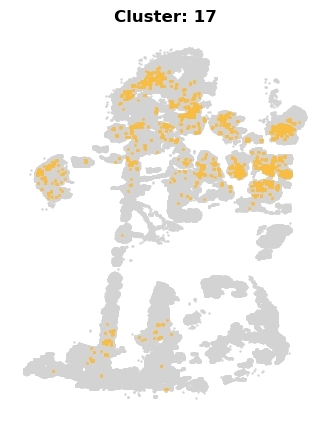

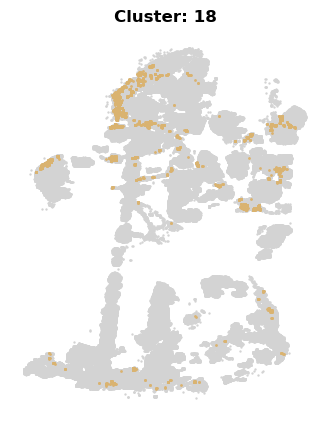

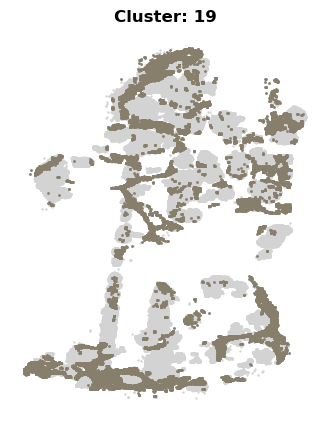

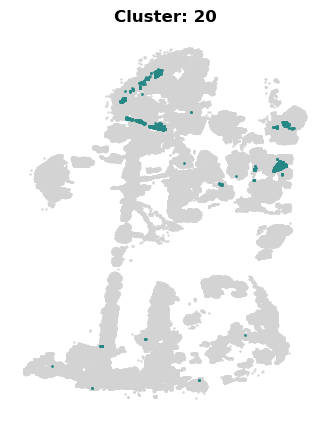

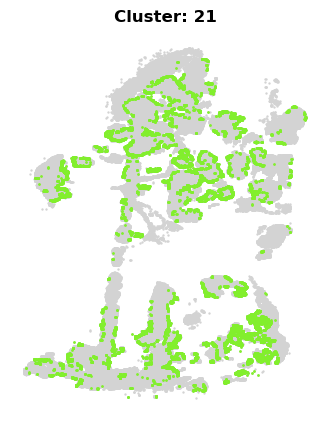

In [9]:
import os
import matplotlib.pyplot as plt
adata.obs['domain'] = adata.obs['domain'].astype('category')
plt.rcParams["figure.figsize"] = (4, 5)
s=24
d='MS19'
#adata.obsm['spatial'][:, 1] = -1 * adata.obsm['spatial'][:, 1]

plot_color = [
    "#F56867", "#556B2F", "#C798EE", "#59BE86", "#006400", "#8470FF",
    "#CD69C9", "#EE7621", "#B22222", "#FFD700", "#CD5555", "#DB4C6C",
    "#8B658B", "#1E90FF", "#AF5F3C", "#CAFF70", "#F9BD3F", "#DAB370",
    "#877F6C", "#268785", "#82EF2D", "#B4EEB4", "#8FBC8F", "#FF6347",
    "#9370DB", "#00CED1", "#FF7F50", "#4682B4", "#7B68EE"
]

# Plot all clusters together
sc.pl.embedding(adata, basis="spatial", color="domain", palette=plot_color, show=False, title="SemanticST")
plt.gca().invert_yaxis()  # Invert the y-axis to match the original plot style
plt.axis('off')
plt.savefig(f"SemanticST_{s}_{d}", dpi=300, bbox_inches='tight')
plt.show()

output_dir = f"Domain_SemanticST_{s}_{d}"
os.makedirs(output_dir, exist_ok=True)

unique_labels = sorted(adata.obs['domain'].unique())  # Ensure consistent order
label_to_color = {label: plot_color[i] for i, label in enumerate(unique_labels)}

# Plot individual clusters
for label in unique_labels:
    fig, ax = plt.subplots()

    ax.scatter(adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1], 
               c='lightgray', s=0.5)

    label_indices = adata.obs['domain'] == label
    ax.scatter(adata.obsm['spatial'][label_indices, 0], 
               adata.obsm['spatial'][label_indices, 1], 
               c=label_to_color[label], s=1)

    ax.set_title(f"Cluster: {label}", fontsize=12, fontweight='bold')
    ax.axis('off')

    plt.gca().invert_yaxis()

    safe_label = str(label).replace("/", "_").replace("\\", "_").replace(":", "_")
    output_file = os.path.join(output_dir, f"{safe_label}.png")
    plt.savefig(output_file, bbox_inches='tight', dpi=300)
